Here we follow the third PyEmma tutorial: http://www.emma-project.org/latest/tutorials/notebooks/03-msm-estimation-and-validation.html#Case-2:-low-dimensional-molecular-dynamics-data-(alanine-dipeptide)

If this link doesn't work try: https://github.com/markovmodel/pyemma_tutorials/blob/master/notebooks/03-msm-estimation-and-validation.ipynb

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import deeptime
import pyemma

## Case 1: Toy Model

From the tutorial:

> We load the two-dimensional trajectory from an archive using numpy and directly discretize the full space using k-means clustering:

In this case, we're going to use the deeptime K-means clustering algorithm: https://deeptime-ml.github.io/latest/notebooks/clustering.html#K-means

We note that there are two types of K-means clustering initialization, and we take a look at both of them.

In [2]:
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans

file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

### Clustering with uniform initialization

In [3]:
estimator = KMeans(
    n_clusters=50,  # place 50 cluster centers
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(data).fetch_model()
assignments = clustering.transform(data)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

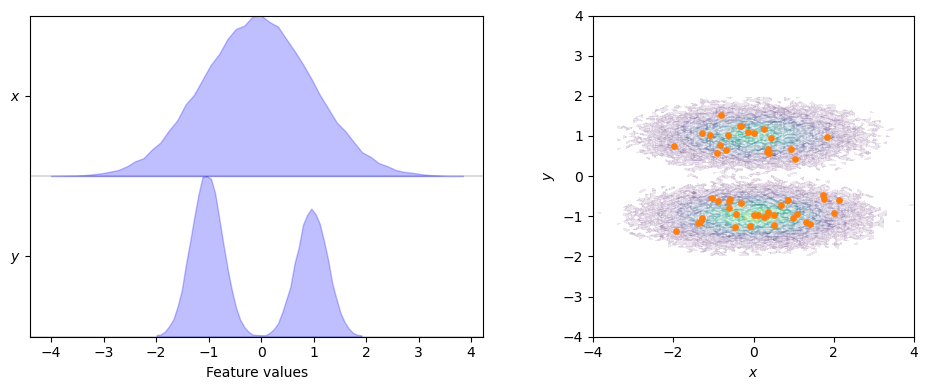

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
#deeptime.plots.plot_density(data[:,1],data[:,0],ax=axes[1])
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

### Clustering with k-means++

In [5]:
estimator = KMeans(
    n_clusters=50,  # place 50 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(data).fetch_model()
assignments = clustering.transform(data)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

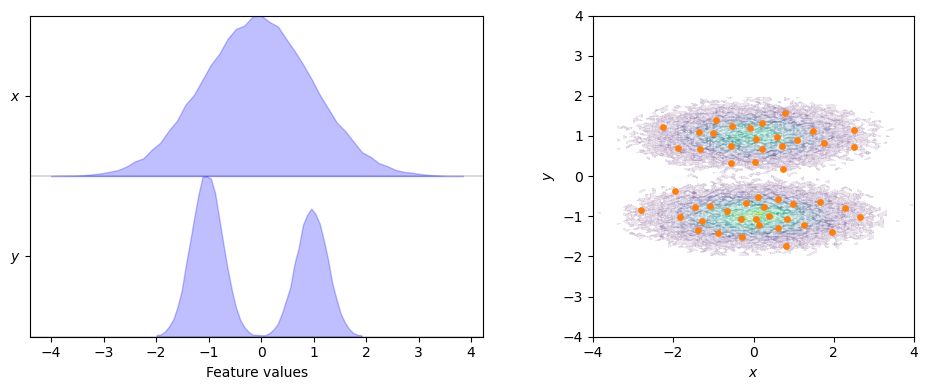

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*(clustering.cluster_centers.T), s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.tight_layout()

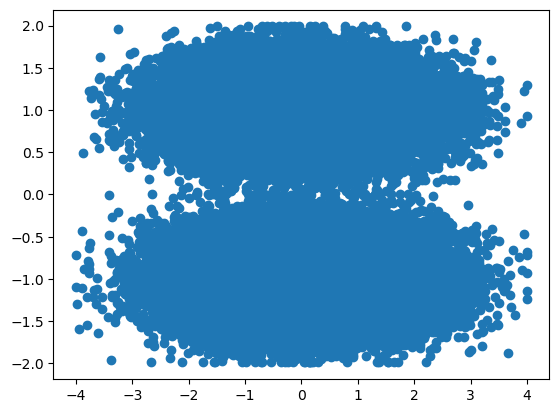

In [7]:
plt.scatter(*data.T)

The second is closer to what the PyEmma function seems to do by default (even if it takes a little longer.)  Be aware!

From the PyEmma tutorial:
> The first step after obtaining the discretized dynamics is finding a suitable lag time. The systematic approach is to estimate MSMs at various lag times and observe how the implied timescales (ITSs) of these models behave. In particular, we are looking for lag time ranges in which the implied timescales are constant (i.e., lag time independent as described in the manuscript in Section 2.1). To this aim, PyEMMA provides the its() function which we use to track the first three (nits=3) implied timescales

There are similar helper functions in deeptime; however, first we need to talk about what an "implied timescale" is.

Recall (or see "An Introduction to Markov State Models and Their Application to Long Timescale Molecular Simulation" or the deeptime documentation on MSMs) that a Markov State Model means finding a model of a process over a set of states, which we assume to be discrete (that's why we did clustering in the last step!).  The Markov state model is associated with a set of probabilities, $P{ij} = P(X_{t+1}=j | X_t = i)$ that are collected in a transition state matrix, and this depends on the lag time, because the way you build the transition matrix is by counting transitions (see https://deeptime-ml.github.io/latest/notebooks/transition-counting.html) which is to say if you are at a state $i$ at one time $t$, what state are you in at a time $t+\tau$, where $\tau$ is the lag time?

The "implied timescale" is another word for the relaxation times of different processes captured by the transition matrix, which are related to the eigenvalues of the matrix as

$$
t_i = -\frac{\tau}{\ln \lambda_i}
$$

Recall that for such a matrix, the largest eigenvalue will always be 1, which gives a $t_1 = \infty$ corresponding to the equilibrium distribution (which never changes or decays).

We usually assume that a model is ``good'' or *valid* if it passes the Chapman-Kolmogorov test / satisfies the Chapman-Kolmogorov equation:

$$
T(n\tau) = T(\tau)^n
$$

This is a formal way of saying that if you take $n$ steps using a model with a lag time of $\tau$, it should be equivalent to taking one step using a model with a lag time of $n\tau$.  

What if this is *not* the case?  What if you get different results from these two different models? You probably haven't fully resolved your process and your assumption that the process is *Markovian* could be violated, so it is *very* important to check implied timescales *and* perform a Chapman-Kolmogorov test to validate your final model.

In [8]:
from deeptime.plots import plot_implied_timescales

Text(0, 0.5, 'timescale (steps)')

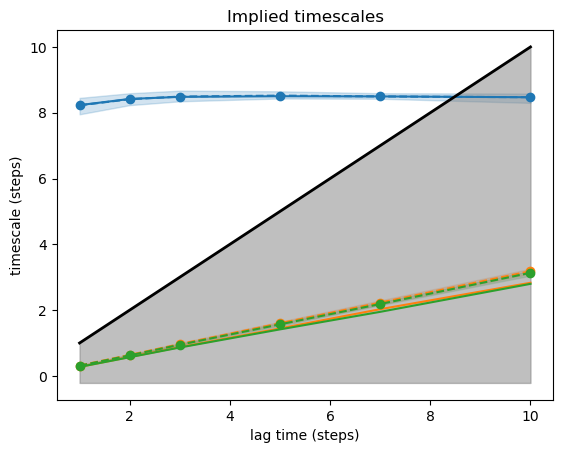

In [9]:
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales
models = []
lagtimes = [1, 2, 3, 5, 7, 10]
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=3, ax=ax)

ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

From the PyEmma tutorial:
> The above plot tells us that there is one resolved process with an ITS of approximately 8.5 steps (blue) which is largely invariant to the MSM lag time. The other two ITSs (green, red) are smaller than the lag time (black line, grey-shaded area); they correspond to processes which are faster than the lag time and, thus, are not resolved. Since the implied timescales are, like the corresponding eigenvalues, sorted in decreasing order, we know that all other remaining processes must be even faster.
> 
> As MSMs tend to underestimate the true ITSs, we are looking for a converged maximum in the ITS plot. In our case, any lag time before the slow process (blue line) crosses the lag time threshold (black line) would work. To maximize the kinetic resolution, we choose the lag time 1 step.
> 
> To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test. Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states. The latter are identified automatically using PCCA++ (which is explained in Notebook 05 📓). We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS. For a single process, we can assume that there are two metastable states between which the process occurs.

to do a CK test with deeptime, we'll need: https://deeptime-ml.github.io/latest/api/generated/deeptime.util.validation.ck_test.html#deeptime.util.validation.ck_test

note also the discussion of how to do PCCA++: https://deeptime-ml.github.io/latest/notebooks/pcca.html

To follow what's done in PyEmma, we'll need to start with a Maximum-likelihood MSM built on the microstates.  From this, we can use PCCA+ (Robust Perron Cluster Cluster Analysis) to coarsegrain the MSM into two metastable states. As said in the PyEmma tutorial description, since we have one resolved slow process, we should look for two metastable states (because the process must be transitioning between two endpoints).

In [10]:
#build Maximum-likelihood MSM (see https://deeptime-ml.github.io/latest/notebooks/mlmsm.html)
import deeptime.markov as markov
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible = True,
    stationary_distribution_constraint = None
)

In [11]:
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="effective"
)
counts = counts_estimator.fit(assignments).fetch_model()
msm = estimator.fit(counts).fetch_model()

In [12]:
#coarsegraining with PCCA+
pcca = msm.pcca(n_metastable_sets=2)

The transition matrix tells us that 93.6% of the time state 1 goes to state 1 and 95% of the time state 2 goes to state 2, but 6.4% of the time state 1 transitions to state 2 and 5% of the time state 2 transitions to state 1 (for the coarsegrained MSM).

If we take a look at the original data and its related probabilities

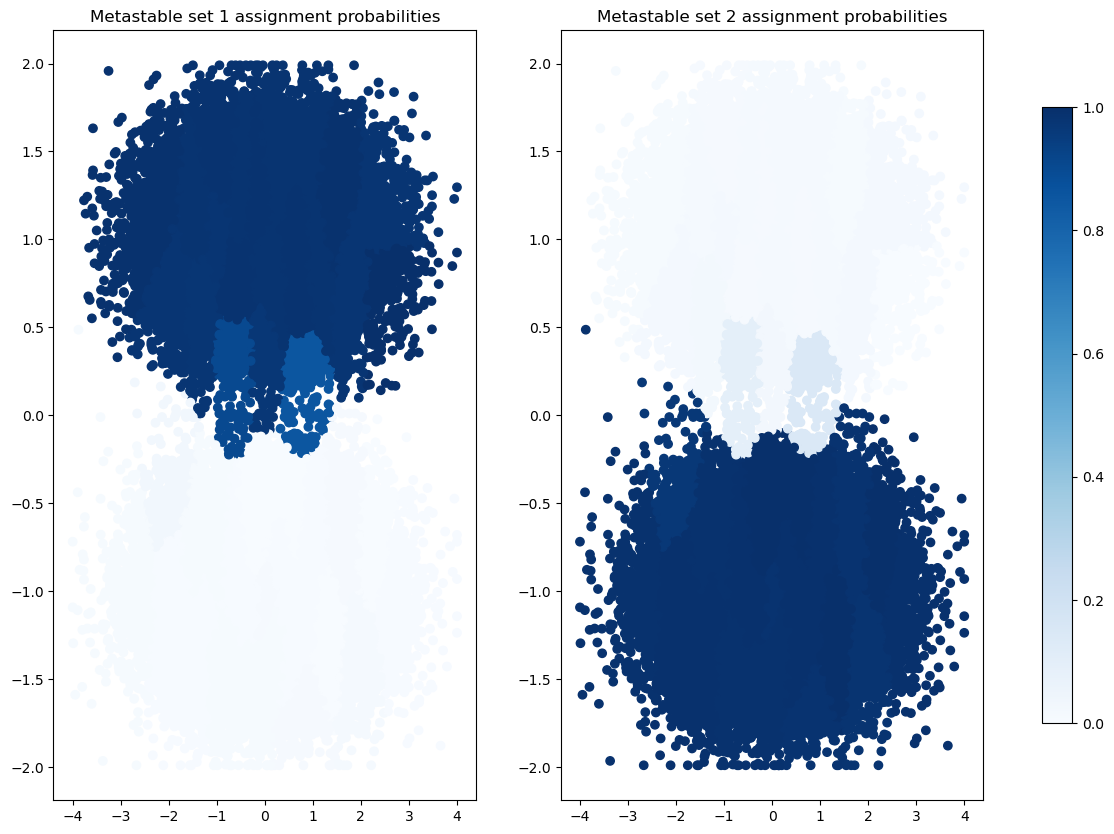

In [13]:
import matplotlib as mpl
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for i in range(len(axes)):
    ax = axes[i]
    ax.set_title(f"Metastable set {i+1} assignment probabilities")

    ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

This partitioning makes sense -- one state is primarily the top basin and the other is primarily the bottom, and there's some fuzziness in the overlapping dots as to the probability of which state they belong to.  So let's go on and try to do the CK test now.

One thing that is confusing is the difference between the MaximumLikelihoodMSM and the BayesianMSM -- the Max Likelihood produces a *single* MSM whereas the Bayesian MSM is itself a *distribution* of MSMs in concordance with the data.  The ways in which these are implemented in `deeptime` are a little obscure, though the algorithms are described according to the 2016 Trendelkamp-Schroer paper.

Note also, for example, that `fit_fetch()` appears equivalent to `fit(input).fetch_models()` which isn't necessarily immediately obvious from the documentation (at least not for me)

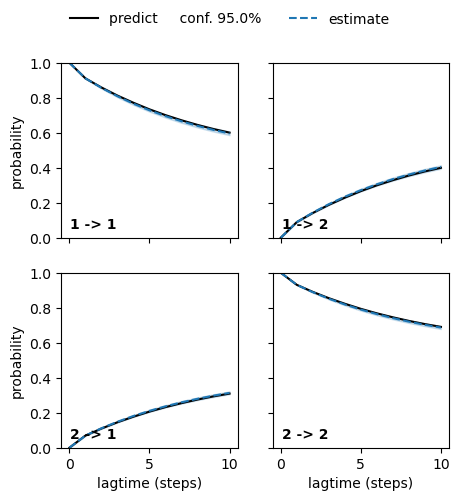

In [14]:
from deeptime.plots.chapman_kolmogorov import plot_ck_test
models = []
for lag in range(1,11):
    counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(assignments)))

test_model = models[0]
ck_test = test_model.ck_test(models,n_metastable_sets=2)
grid = plot_ck_test(ck_test,legend=True)

So what we see is that the *estimated* models for higher lag times meet the *predicted* model for the lag 1 time step. As the PyEmma tutorial notes,
> We can see a perfect agreement between models estimated at higher lag times and predictions of the model at lag time 1 step. Thus, we have estimated a valid MSM according to basic model validation.

> Should a CK test fail, it means that the dynamics in the space of metastable states is not Markovian. This can have multiple causes since it is the result of the combination of all steps in the pipeline. In practice, one would attempt to find a better model by tuning hyper-parameters such as the number of metastable states, the MSM lag time or the number of cluster centers. Back-tracking the error by following the pipeline in an upstream direction, i.e., by starting with the number of metastable states, is usually advised.

> A failing CK test might further hint at poor sampling. This case is explained in more detail in Notebook 08 📓.

## Alanine Dipeptide
We're onto the marginally more interesting case of alanine dipeptide (still kind of a boring toy model). Accordingly,

> We fetch the alanine dipeptide data set, load the backbone torsions into memory and directly discretize the full space using k-means clustering. In order to demonstrate how to adjust the MSM lag time, we will first set the number of cluster centers to 200 and justify this choice later.

Note: if your `mdshare.fetch` call breaks with an error stating that `ipywidgets has no attribute version_info` you can solve it by downgrading to ipywidgets version 7.7.

In [1]:
from localfeaturizers import local_dihedral_featurizer
import mdshare
import mdtraj as mdt

pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

In [2]:
trajs = []
for f in files:
    traj = mdt.load(f,top=pdb)
    trajs.append(traj)

In [3]:
trajs

[<mdtraj.Trajectory with 250000 frames, 22 atoms, 3 residues, and unitcells at 0x2be93257d10>,
 <mdtraj.Trajectory with 250000 frames, 22 atoms, 3 residues, and unitcells at 0x2be925b6d10>,
 <mdtraj.Trajectory with 250000 frames, 22 atoms, 3 residues, and unitcells at 0x2be92803d90>]

In [4]:
dihslist = local_dihedral_featurizer(trajs,False,sincos=False,psiphionly=True)

In [5]:
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans

estimator = KMeans(
    n_clusters=200,  # place 50 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=50,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

clustering = estimator.fit(dihslist).fetch_model()


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\raman\anaconda3\envs\msm-env\Lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


In [6]:
dtrajs = [clustering.transform(dihslist[i]) for i in range(len(dihslist))]

PyEmma Tutorial:
> From the discrete trajectories, implied timescales can be estimated:

Text(0, 0.5, 'timescale (steps)')

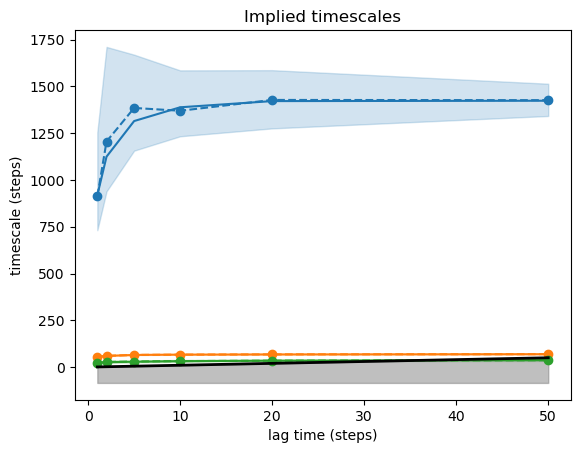

In [9]:
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

models = []
lagtimes = [1, 2, 5, 10, 20, 50]
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=3, ax=ax)

ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

This is a little messy looking because we plotted it linearly.  Let's go on and continue following the PyEmma tutorial:
> We visualize the marginal and joint distributions of both components as well as the cluster centers, and show the ITS convergence to help selecting a suitable lag time:

In [10]:
data_concatenated = np.vstack(dihslist)

In [11]:
data_concatenated.shape

(750000, 2)

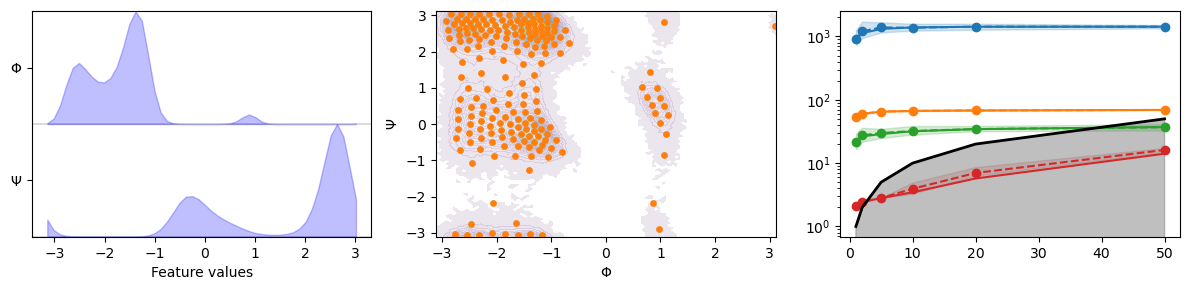

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(data_concatenated[:,0],data_concatenated[:,1], ax=axes[1],cbar=False,alpha=0.1)
axes[1].scatter(*clustering.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
plot_implied_timescales(its_data, n_its=4, ax=axes[2])
axes[2].set_yscale('log')
fig.tight_layout()

From the PyEmma tutorial:
> We observe three resolved processes with flat ITS for a lag time of approximately 10 ps.
> Please note though that this ITS convergence analysis is based on the assumption that 200 k-means centers are sufficient to discretize the dynamics. In order to study the influence of the clustering on the ITS convergence, we repeat the clustering and ITS convergence analysis for various number of cluster centers. For the sake of simplicity, we will restrict ourselves to the k-means algorithm; alternative clustering methods are presented in Notebook 02 ➜ 📓

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\raman\anaconda3\envs\msm-env\Lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

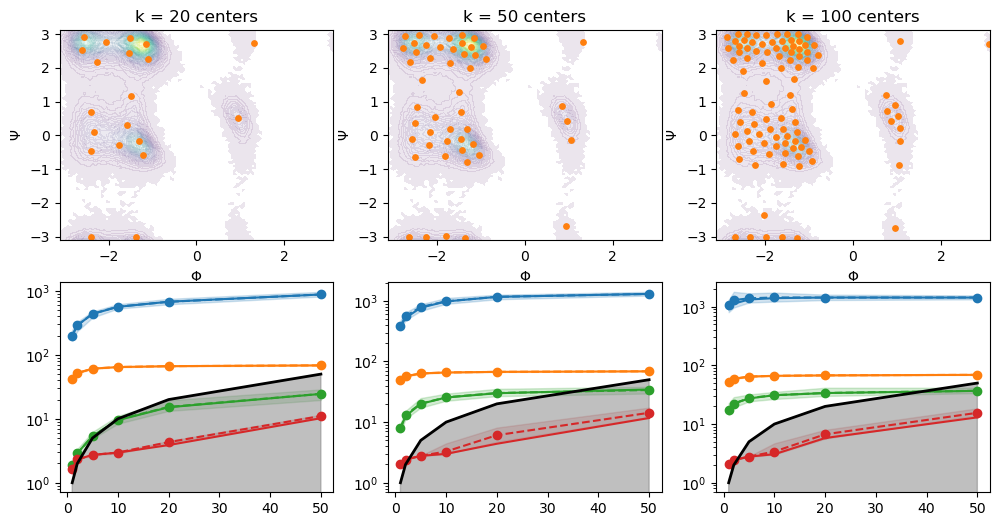

In [13]:
fig, axes = plt.subplots(2,3, figsize=(12,6))
for i, k in enumerate([20, 50, 100]):
    estimator = KMeans(
        n_clusters=k,  # place 50 cluster centers
        init_strategy='kmeans++',  # kmeans++ initialization strategy
        max_iter=50,  # don't actually perform the optimization, just place centers
        fixed_seed=13,
        n_jobs=8,
        progress=tqdm
    )
    
    clustering = estimator.fit(dihslist).fetch_model()
    pyemma.plots.plot_density(data_concatenated[:,0],data_concatenated[:,1], ax=axes[0,i],cbar=False,alpha=0.1)
    axes[0,i].scatter(*clustering.cluster_centers.T, s=15, c='C1')
    axes[0,i].set_xlabel('$\Phi$')
    axes[0,i].set_ylabel('$\Psi$')
    axes[0,i].set_title('k = {} centers'.format(k))
    models = []
    lagtimes = [1, 2, 5, 10, 20, 50]
    dtrajs = [clustering.transform(dihslist[i]) for i in range(len(dihslist))]
    for lagtime in lagtimes:
        counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(dtrajs)
        models.append(BayesianMSM(n_samples=50).fit_fetch(counts))
    
    its_data = implied_timescales(models)

    plot_implied_timescales(its_data, n_its=4, ax=axes[1,i])
    axes[1,i].set_yscale('log')

From the PyEmma tutorial:
> We can see from this analysis that the ITS curves indeed converge towards the 200 centers case and we can continue with estimating/validating an MSM.

> Before we continue with MSM estimation, let us discuss implied timescales convergence for large systems. Given sufficient sampling, the task is often to find a discretization that captures the process of interest well enough to obtain implied timescales that converge within the trajectory length.

>As we see in the above example with k=20 cluster centers, increasing the MSM lag time compensates for poor discretization to a certain extent. In a more realistic system, however, trajectories have a finite length that limits the choice of our MSM lag time. Furthermore, our clustering might be worse than the one presented above, so convergence might not be reached at all. Thus, we aim to converge the implied timescales at a low lag time by fine-tuning not only the number of cluster centers, but also feature selection and dimension reduction measures. This additionally ensures that our model has the maximum achievable temporal resolution.

> Please note that choosing an appropriate MSM lag time variationally (e.g., using VAMP scoring) is as far as we know not possible.

> Further details on how to account for poor discretization can be found in our notebook about hidden Markov models Notebook 07 📓. An example on how implied timescales behave in the limit of poor sampling is shown in Notebook 08 📓.

> Now, let’s continue with the alanine dipeptide system. We estimate an MSM at lag time 10 ps and, given that we have three slow processes, perform a CK test for four metastable states.

> ⚠️ In general, the number of metastable states is a modeler’s choice and will be explained in more detail in Notebook 04 ➜ 📓 and Notebook 07 ➜ 📓.

Note in what follows the difference in usage.  We explicitly fit Bayesian MSM ensembles for each lag time from 1 to 100 ps, then choose the model we which to test (the 10th model, which has a lagtime of 10 ps) and that is what is used to perform the CK test against the other models.

In [14]:
help(deeptime.markov.msm.MarkovStateModel.ck_test)

Help on function ck_test in module deeptime.markov.msm._markov_state_model:

ck_test(self, models, n_metastable_sets, include_lag0=True, err_est=False, progress=None)
    Validates a model estimated at lag time tau by testing its predictions for longer lag times.
    This is known as the Chapman-Kolmogorov test as it is based on the Chapman-Kolmogorov equation.
    The test is performed on metastable sets of states rather than the micro-states themselves.
    
    Parameters
    ----------
    models : list of MarkovStateModel
        A list of models which were estimated at different and in particular longer lagtimes.
    n_metastable_sets : int
        Number of metastable sets, estimated via :meth:`pcca`.
    include_lag0 : bool, optional, default=True
        Whether to include a lagtime 0 in the test, which corresponds to an identity transition matrix for MSMs.
    err_est : bool, optional, default=False
        Whether to compute errors on observable evaluations of the models in 

In [15]:
help(deeptime.util.validation.ck_test)

Help on function ck_test in module deeptime.util.validation:

ck_test(models, observable: deeptime.base.Observable, test_model=None, include_lag0=True, err_est=False, progress=None)
    Performs a Chapman-Kolmogorov test: Under the assumption of Markovian dynamics some transfer operators
    such as the transition matrix of a Markov state model or a Koopman model possess the so-called Chapman-Kolmogorov
    property. It states that for lagtimes :math:`\tau_1, \tau_2` the transfer operator behaves like
    :math:`\mathcal{T}_{\tau_1 + \tau_2} = \mathcal{T}_{\tau_1}\mathcal{T}_{\tau_2}`.
    
    This method performs a test to verify the above identity by evaluating an observable :math:`\rho` *twice*
    on a range of different lagtimes. The observable evaluated on each model (estimated at a different lagtime)
    is compared against the observable evaluated on the test model when it is propagated by the Chapman-Kolmogorov
    equation to the corresponding lagtime:
    
    .. math::
   

In [16]:
help(deeptime.plots.plot_ck_test)

Help on function plot_ck_test in module deeptime.plots.chapman_kolmogorov:

plot_ck_test(data: deeptime.util.validation.ChapmanKolmogorovTest, height=2.5, aspect=1.0, conf: float = 0.95, color=None, grid: deeptime.plots.chapman_kolmogorov.CKTestGrid = None, legend=True, xlabel='lagtime (steps)', ylabel='probability', y01=True, sharey=True, **plot_kwargs)
    Plot the Chapman Kolmogorov test.
    
    .. plot:: examples/plot_ck_test.py
    
    Parameters
    ----------
    data : ChapmanKolmogorovTest
        Result of :meth:`ck_test <deeptime.util.validation.ck_test>`.
    height : float, default=2.5
        Figure height.
    aspect : float, default=1.
        Aspect of individual plots.
    conf : float, default=0.95
        Confidence interval probability.
    color : color, optional, default=None
        The color to use for predictions. Per default uses default colors.
    grid : CKTestGrid, optional, default=None
        An already existing grid view of a ck-test to overlay.
   

In [17]:
models = []
for lag in range(10,100):
    counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(dtrajs)))



NameError: name 'plot_ck_test' is not defined

C:\Users\raman\anaconda3\envs\msm-env\Lib\site-packages\deeptime\plots\chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


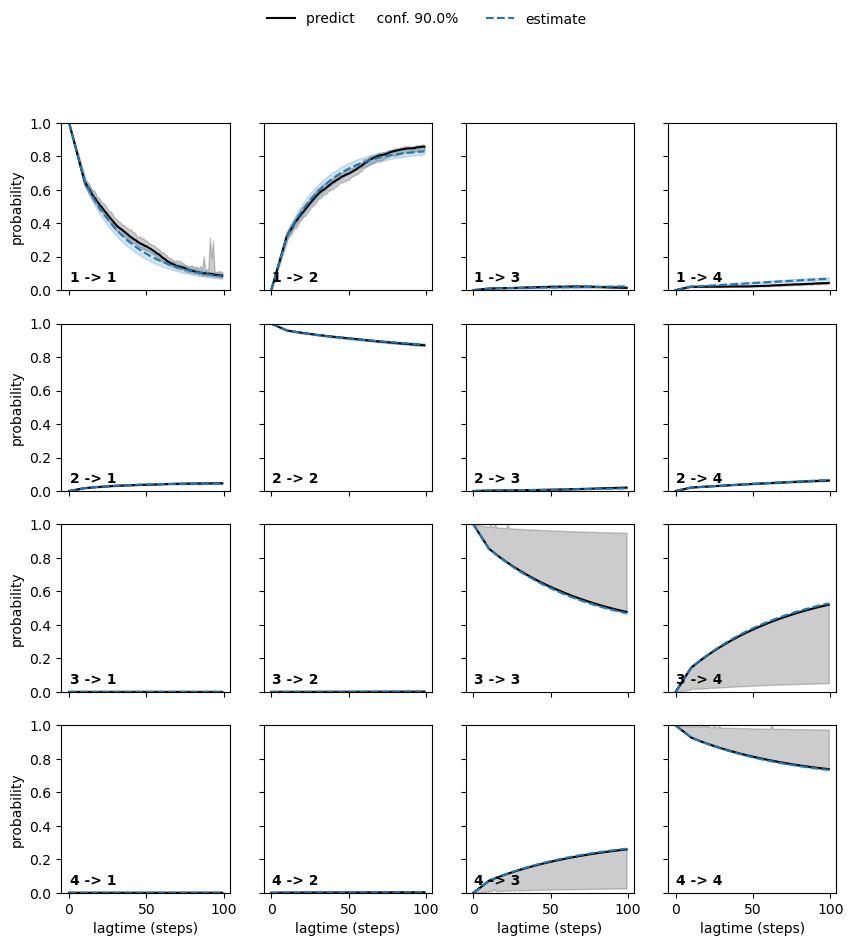

In [18]:
from deeptime.plots import plot_ck_test
test_model = models[1]
ck_test = test_model.ck_test(models,n_metastable_sets=4,err_est=True)
grid = plot_ck_test(ck_test,legend=True,conf=0.9)

## Persisting and restoring estimators

The next section in the tutorial discusses using PyEmma tools to save models to a file. This appears to have been broken for a fairly long time in PyEmma, so I'm going to just write a little bit about how you can do this using the Python package `pickle`. Do note that there are security issues with this package and that you should only unpickle things that you yourself have pickled (don't take a pickled object from someone on the internet and assume that it won't do bad stuff; this is akin to clicking on a `photoshop.exe` downloaded from the internet, which totally isn't a virus, it promises.

In [19]:
import pickle

In [ ]:
fname = 'step2-diala-estimaor.pkl'
f = open(fname,'wb')
pickle.dump(models,f)
f.close()

In [ ]:
of = open(fname,'rb')
loadedmodels = pickle.load(of)
of.close()